In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import itertools

In [4]:
load_file_path=os.path.join('/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/fashion', 'Copy of fashion_result.csv')
print(load_file_path)

save_folder='/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/fashion'

/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/fashion/Copy of fashion_result.csv


In [5]:
# Load the CSV file into a dataframe
dataframe = pd.read_csv(load_file_path)

add flops col

In [6]:
def preprocess_dataframe(df, flops_dict):
    # Step 1: Modify column names and remove specific columns
    df.rename(columns={'conv1x1_3x3.1': 'conv1x1_3x3', 'conv1x1_5x5.1': 'conv1x1_5x5'}, inplace=True)
    df.drop(columns=['conv1x1_3x3.0', 'conv1x1_5x5.0'], inplace=True)

    # Step 2: Add FLOPS columns
    for col, value in flops_dict.items():
        df[col] = value

    return df

# Example usage:
flops_dict = {"conv1x1FLOPS": 0.012544, "conv1x1_3x3FLOPS": 0.909, "conv1x1_5x5FLOPS": 2.515, "totalFLOPS": 13.274}
df = preprocess_dataframe(dataframe, flops_dict)

normalize layer feature attribution in this stack

In [7]:
def normalize_feature_attribution_final(df):
    """
    Final modification of the normalization of feature attributions for each layer.

    Parameters:
    df (DataFrame): The dataframe containing the feature attributions.

    Returns:
    DataFrame: A modified dataframe with normalized feature attributions for each layer.
    """
    # Columns to be normalized
    layers = ['conv1x1', 'conv1x1_3x3', 'conv1x1_5x5']

    # New sum calculation using specific layers
    df['sum_feature_attr'] = df[layers].sum(axis=1)

    # Normalize each layer by dividing by the new sum of feature attributions
    for layer in layers:
        df[f'norm_{layer}'] = df[layer] / df['sum_feature_attr']

    df.drop(['sum_feature_attr','conv1x1',	'conv1x1_3x3',	'conv1x1_5x5'], axis=1, inplace=True)

    return df

# Example usage of the final modified function
normalized_final_df = normalize_feature_attribution_final(df.copy())

get average and normalzied variance for each combination of hyperparameter

In [8]:
def calculate_normalized_variance(df, method, flops_dict):
    """
    Modified combined function to calculate the average and normalized variance of each layer's feature attribution
    for a given method, including both average and variance in one dataframe, along with average accuracy after each epoch.
    This version also includes FLOPS information.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    method (str): The method to filter the data ('deeplift' or 'integrated_gradients').
    flops_dict (dict): Dictionary containing FLOPS values for different layers.

    Returns:
    DataFrame: A dataframe with the average and normalized variance for each layer combined, and average accuracy after each epoch, including FLOPS info.
    """
    # Filter the dataframe based on the method
    filtered_df = df[df['method'] == method]

    # Columns for which to calculate average and normalized variance, excluding certain layers
    layers = ['norm_conv1x1', 'norm_conv1x1_3x3', 'norm_conv1x1_5x5']
    accuracy_columns = ['train accuracy epoch0', 'test accuracy epoch0']

    # Group by hyperparameters and calculate mean and variance for feature attributions and accuracy
    grouped = filtered_df.groupby(['initial_lr', 'optimizer', 'criterion', 'train_data_used', 'train_set_shuffle', 'train_batch_size'])
    avg_norm = grouped[layers].mean()
    var_norm = grouped[layers].var()
    avg_acc = grouped[accuracy_columns].mean()

    # Calculate normalized variance (variance/mean)
    norm_var = var_norm / avg_norm

    # Combine average and normalized variance into one dataframe
    combined_df = avg_norm.copy()
    for layer in layers:
        combined_df[f'norm_var_{layer}'] = norm_var[layer]

    # Calculate the average normalized variance across the selected layers
    norm_var_layers = [f'norm_var_{layer}' for layer in layers]
    combined_df['avg_normalized_variance'] = combined_df[norm_var_layers].mean(axis=1)

    # Adding average accuracy columns
    for acc_col in accuracy_columns:
        combined_df[acc_col] = avg_acc[acc_col]

    # Add FLOPS information
    for flops_key, flops_value in flops_dict.items():
        combined_df[flops_key] = flops_value

    return combined_df

# Example usage
combined_avg_norm_var_acc_integrated_gradients = calculate_normalized_variance(normalized_final_df, 'integrated_gradients', flops_dict)

In [9]:
combined_avg_norm_var_acc_integrated_gradients.to_csv(save_folder+"/fashion ig.csv")
combined_avg_norm_var_acc_integrated_gradients=pd.read_csv(save_folder+"/fashion ig.csv")

In [10]:
def filter_by_accuracy(df, threshold=70.0):
    """
    Function to filter out rows where the average accuracy across epoch 3 (both train and test) is lower than a specified threshold.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    threshold (float): The threshold for average accuracy in epoch 3.

    Returns:
    DataFrame: A filtered dataframe with rows having average epoch 3 accuracy higher than the threshold.
    """
    # Columns representing epoch 3 accuracy
    epoch_3_accuracy_cols = ['test accuracy epoch0']

    # Calculate the average accuracy for epoch 3
    df['final_test_accuracy'] = df[epoch_3_accuracy_cols].mean(axis=1)

    # Filter the dataframe based on the threshold
    filtered_df = df[df['final_test_accuracy'] >= threshold]

    return filtered_df

# Apply the function to the dataframes for 'deeplift' and 'integrated_gradients'
filtered_integrated_gradients = filter_by_accuracy(combined_avg_norm_var_acc_integrated_gradients)

# Display the first few rows of the filtered dataframes
filtered_integrated_gradients

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,norm_conv1x1,norm_conv1x1_3x3,norm_conv1x1_5x5,norm_var_norm_conv1x1,norm_var_norm_conv1x1_3x3,norm_var_norm_conv1x1_5x5,avg_normalized_variance,train accuracy epoch0,test accuracy epoch0,conv1x1FLOPS,conv1x1_3x3FLOPS,conv1x1_5x5FLOPS,totalFLOPS,final_test_accuracy
0,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.416394,0.175743,0.407863,0.012021,0.040233,0.029274,0.027176,83.219333,85.513333,0.012544,0.909,2.515,13.274,85.513333
1,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.417140,0.212486,0.370374,0.013948,0.035663,0.031598,0.027069,82.959333,84.959333,0.012544,0.909,2.515,13.274,84.959333
2,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.425429,0.234686,0.339886,0.010877,0.025622,0.022240,0.019579,82.262778,84.261333,0.012544,0.909,2.515,13.274,84.261333
3,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.400063,0.181994,0.417943,0.012392,0.054290,0.031861,0.032848,83.259444,85.304000,0.012544,0.909,2.515,13.274,85.304000
4,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.403714,0.207015,0.389271,0.011616,0.044082,0.029096,0.028265,82.943889,85.282667,0.012544,0.909,2.515,13.274,85.282667
5,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.418670,0.233436,0.347894,0.008131,0.028558,0.022649,0.019779,82.406667,84.660667,0.012544,0.909,2.515,13.274,84.660667
6,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.435766,0.207643,0.356591,0.013266,0.069615,0.051625,0.044835,82.666778,85.055333,0.012544,0.909,2.515,13.274,85.055333
7,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.455734,0.219431,0.324834,0.014151,0.050222,0.044924,0.036432,82.656778,84.782667,0.012544,0.909,2.515,13.274,84.782667
8,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.485669,0.220274,0.294058,0.009983,0.026083,0.031473,0.022513,82.031444,84.282667,0.012544,0.909,2.515,13.274,84.282667
9,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.430872,0.201717,0.367411,0.011188,0.071913,0.051631,0.044911,82.759000,84.548667,0.012544,0.909,2.515,13.274,84.548667


# Graph

In [11]:
def plot_variance_for_multiple_hyperparam_values(df, hyperparam, variables):
    """
    Plots bar graphs of the average variance of each layer and the overall average variance
    for multiple values of a given hyperparameter.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    hyperparam (str): The hyperparameter to vary.
    variables (list): A list of values for the hyperparameter to compare.

    Returns:
    None: The function plots graphs directly.
    """
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = [col for col in df.columns if 'norm_var' in col]
    variance_columns.append('avg_normalized_variance')

    # Preparing data for plotting
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var]
        avg_variances = subset[variance_columns].mean().to_frame().T
        avg_variances['hyperparam_value'] = var
        plot_data = pd.concat([plot_data, avg_variances])

    plot_data.set_index('hyperparam_value', inplace=True)

    # Plotting average variance for each layer and overall average
    plot_data.plot(kind='bar')
    plt.title(f'Average Variance for Different {hyperparam} Values')
    plt.ylabel('Average Variance')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.show()


In [12]:
filtered_integrated_gradients.to_csv(save_folder+"/fashion ig ave var.csv")

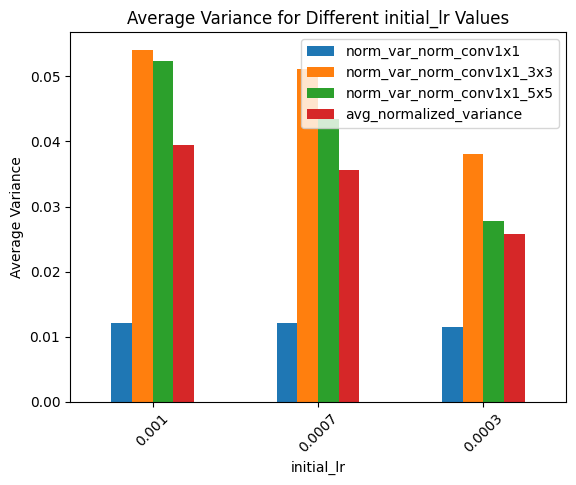

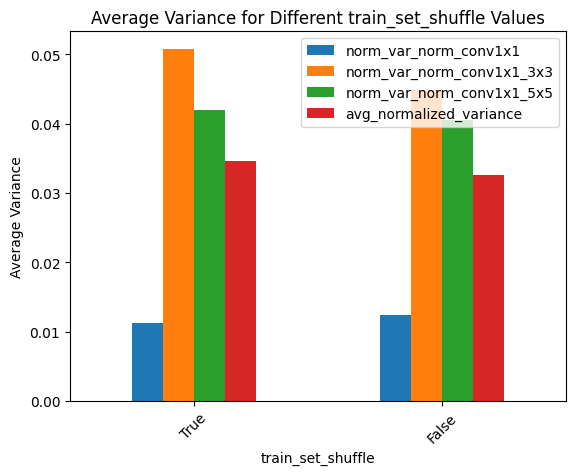

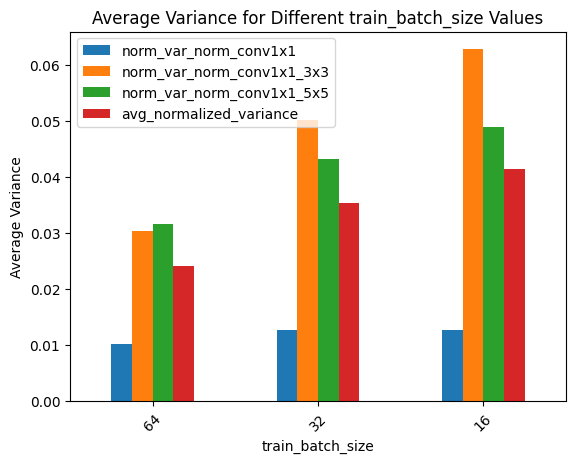

In [13]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_set_shuffle': [True,False],
    'train_batch_size': [64, 32, 16]
}

for hyperparam, variables in hyperparams_choice_list.items():
    plot_variance_for_multiple_hyperparam_values(filtered_integrated_gradients, hyperparam, variables)

# T test

In [14]:
def perform_t_test(df, target_column, condition_column, choice1, choice2):
    # Splitting the data into two groups based on the condition
    group1 = df[df[condition_column] == choice1][target_column]
    group2 = df[df[condition_column] == choice2][target_column]

    # Performing the independent t-test
    t_statistic, p_value = ttest_ind(group1, group2)

    return t_statistic, p_value

initial_lr

In [15]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0007)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 0.7131257471583953 P-value: 0.49207386268477893


In [16]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'initial_lr', 0.0007, 0.0003)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 2.2548159109072654 P-value: 0.047787341872250824


In [17]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0003)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 3.0563252496660502 P-value: 0.012120214732954564


train_set_shuffle

In [18]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'train_set_shuffle', True, False)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 0.43977364493328414 P-value: 0.6659834075561588


train_batch_size

In [19]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'train_batch_size', 64, 32)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -3.7105768944163438 P-value: 0.004037471758616571


In [20]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'train_batch_size', 64, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -4.207733246552481 P-value: 0.001806401870730416


In [21]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'train_batch_size', 32, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -1.3262282792762616 P-value: 0.2142562136682214


# Paired T test

In [22]:
def one_sided_paired_ttest(data_set1, data_set2):
    """
    Perform a one-sided paired t-test to determine if the first data set is statistically larger than the second.

    Parameters:
    data_set1 (array-like): The first set of data.
    data_set2 (array-like): The second set of data.

    Returns:
    tuple: A tuple containing the t-statistic and the one-sided p-value.
    """
    t_statistic, p_value = ttest_rel(data_set1, data_set2)

    # Adjust p-value for one-sided test
    if t_statistic > 0:
        p_value_one_sided = p_value / 2
    else:
        p_value_one_sided = 1 - (p_value / 2)

    return t_statistic, p_value_one_sided

# Example usage:
# t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
# print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)


In [23]:
def find_rows_with_fixed_conditions(df, conditions):
    # Filter the DataFrame based on the conditions
    filtered_df = df
    for column, value in conditions.items():
        filtered_df = filtered_df[filtered_df[column] == value]

    return filtered_df

In [24]:
def generate_hyperparameter_combinations(hyperparams):
    """
    Generate a sequence of hyperparameter combinations.

    :param hyperparams: A dictionary where keys are the names of hyperparameters,
                        and values are lists of possible choices for each hyperparameter.
    :return: A list of dictionaries, each representing a unique combination of hyperparameters.
    """
    # Extract the hyperparameter names and their corresponding choices
    keys, values = zip(*hyperparams.items())

    # Generate all possible combinations of hyperparameter values
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    return all_combinations

In [25]:
def get_all_pairs(df, hyperparams_choice_list, target_column, condition_column, choice1, choice2):
    hyperparams_choice_list_compressed = {key: value for key, value in hyperparams_choice_list.items() if key != condition_column}
    all_combinations = generate_hyperparameter_combinations(hyperparams_choice_list_compressed)
    choice1_target_values=[]
    choice2_target_values=[]
    for conditions in all_combinations:
      x = find_rows_with_fixed_conditions(df, conditions)
      try:
        choice1_value = float(x[x[condition_column] == choice1][target_column])
        choice2_value = float(x[x[condition_column] == choice2][target_column])
        print(choice1_value, choice2_value)
      except:
        continue
      choice1_target_values.append(choice1_value)
      choice2_target_values.append(choice2_value)
    return choice1_target_values, choice2_target_values

initial_lr

In [26]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0007)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0292087192475562 0.0265160933065436
0.0422133209187265 0.0384057267721206
0.049972873863942 0.0449108088232437
0.0268745372396222 0.0225126572651678
0.0399161808054389 0.0364324219955661
0.0489411192924455 0.0448352982419005
T-statistic: 11.918605308761698 One-sided P-value: 3.6638342987522346e-05


In [27]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.0007, 0.0003)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0265160933065436 0.0197791698339821
0.0384057267721206 0.0282647586861679
0.0449108088232437 0.0328480447910859
0.0225126572651678 0.0195794868148592
0.0364324219955661 0.0270694975850889
0.0448352982419005 0.0271763848120582
T-statistic: 4.833541069089991 One-sided P-value: 0.002370862212959337


In [28]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0003)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0292087192475562 0.0197791698339821
0.0422133209187265 0.0282647586861679
0.049972873863942 0.0328480447910859
0.0268745372396222 0.0195794868148592
0.0399161808054389 0.0270694975850889
0.0489411192924455 0.0271763848120582
T-statistic: 6.431671364943896 One-sided P-value: 0.0006749478620816953


train_set_shuffle

In [29]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'train_set_shuffle', True, False)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0292087192475562 0.0268745372396222
0.0422133209187265 0.0399161808054389
0.049972873863942 0.0489411192924455
0.0265160933065436 0.0225126572651678
0.0384057267721206 0.0364324219955661
0.0449108088232437 0.0448352982419005
0.0197791698339821 0.0195794868148592
0.0282647586861679 0.0270694975850889
0.0328480447910859 0.0271763848120582
T-statistic: 3.4623098653759974 One-sided P-value: 0.004269365494992807


train_batch_size

In [30]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 32, 64)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0422133209187265 0.0292087192475562
0.0399161808054389 0.0268745372396222
0.0384057267721206 0.0265160933065436
0.0364324219955661 0.0225126572651678
0.0282647586861679 0.0197791698339821
0.0270694975850889 0.0195794868148592
T-statistic: 10.379966914575194 One-sided P-value: 7.145759607702417e-05


In [31]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 16, 32)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.049972873863942 0.0422133209187265
0.0489411192924455 0.0399161808054389
0.0449108088232437 0.0384057267721206
0.0448352982419005 0.0364324219955661
0.0328480447910859 0.0282647586861679
0.0271763848120582 0.0270694975850889
T-statistic: 4.478934609498396 One-sided P-value: 0.0032625645199400944


In [32]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 16, 64)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.049972873863942 0.0292087192475562
0.0489411192924455 0.0268745372396222
0.0449108088232437 0.0265160933065436
0.0448352982419005 0.0225126572651678
0.0328480447910859 0.0197791698339821
0.0271763848120582 0.0195794868148592
T-statistic: 7.22933725847247 One-sided P-value: 0.00039502978468239624


#layer feature attribution rank frequency comparison

In [33]:
normalized_df = normalized_final_df[normalized_final_df['method'] == 'integrated_gradients']
normalized_df_highacc = filter_by_accuracy(normalized_df)
normalized_df_highacc

<ipython-input-10-4ef74943cc56>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['final_test_accuracy'] = df[epoch_3_accuracy_cols].mean(axis=1)


,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,train accuracy epoch0,test accuracy epoch0,method,run,conv1x1FLOPS,conv1x1_3x3FLOPS,conv1x1_5x5FLOPS,totalFLOPS,norm_conv1x1,norm_conv1x1_3x3,norm_conv1x1_5x5,final_test_accuracy
1,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,82.455000,84.27,integrated_gradients,0,0.012544,0.909,2.515,13.274,0.539976,0.209749,0.250274,84.27
3,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,82.041667,83.46,integrated_gradients,1,0.012544,0.909,2.515,13.274,0.413582,0.216123,0.370295,83.46
5,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,82.341667,85.07,integrated_gradients,2,0.012544,0.909,2.515,13.274,0.428732,0.180761,0.390506,85.07
7,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,81.900000,84.41,integrated_gradients,3,0.012544,0.909,2.515,13.274,0.480419,0.244895,0.274686,84.41
9,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,82.288333,84.38,integrated_gradients,4,0.012544,0.909,2.515,13.274,0.410994,0.326926,0.262079,84.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,83.273333,85.02,integrated_gradients,10,0.012544,0.909,2.515,13.274,0.396802,0.039487,0.563712,85.02
533,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,83.376667,85.91,integrated_gradients,11,0.012544,0.909,2.515,13.274,0.499436,0.084122,0.416442,85.91
535,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,82.953333,85.95,integrated_gradients,12,0.012544,0.909,2.515,13.274,0.220450,0.178560,0.600990,85.95
537,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,83.060000,85.83,integrated_gradients,13,0.012544,0.909,2.515,13.274,0.446000,0.164294,0.389707,85.83


In [34]:
# Select the columns of interest
cols_of_interest = ['norm_conv1x1', 'norm_conv1x1_3x3', 'norm_conv1x1_5x5']
data_subset = normalized_df_highacc[cols_of_interest]

# Function to get rank as a string
def get_rank_string(row):
    return ''.join(row.rank().astype(int).astype(str))

# Apply the function to each row
data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)

# Count the frequency of each rank combination
rank_combination_counts = data_subset['rank_combination'].value_counts()

rank_combination_counts

<ipython-input-34-2b13f1656abd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)


312    143
213     64
321     51
231     10
123      2
Name: rank_combination, dtype: int64